# Fitting
Fitting enables the identification of trends and behaviours in datasets. A fit describes a model of the data matched to the dataset. The fit produced can then be used to identify outliers or predict future behaviour. Much effort has been applied to modelling and exotic numerical techniques like neural networks and gradient trees are widely used today. This Section will focus on least-squares fitting of curves and goodness of fit metrics. 

In the context of the $\textrm{CO}_2$ data, this chapter is interested in the behaviour of the year 2020 in comparison to previous years. 

In [1]:
from dur_utils import colours #Durham Utilities module that stores constants like colours, can be found on _githublink_
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize 
import matplotlib as mpl
plt.style.use('../CDS.mplstyle')

In [2]:
path_global = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv'
co2_data_global = pd.read_csv(path_global, header=0, comment='#')
path_ml =  'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'              
co2_data_ml = pd.read_csv(path_ml, header=0, comment='#')
co2_data_ml = co2_data_ml[co2_data_ml['sdev']>0] 

## Least-Squares Fitting 
When performing curve fitting, the method of non-linear least-squares fitting is typically appropriate. The principle behind least-squares fitting is reducing the residual between the data and the fit. The N point residual for a scalar function, 
```{math}
:label: Residuals
r = \sum_{i = 0}^N(y'(\vec{x_i},\vec{p})-y(\vec{x_i}))^2.
``` 
Where  $y'(\vec{x},\vec{p})$  is the model function and  $y(\vec{x})$  the data. 

For a scalar function, the fitted line  $ y'(x,\vec{p})$  is a function of the data and the free parameters of the curve $ \vec{p} \in \mathbb{R}^m $. An iterative solution to minimise the residuals can be found for any non-linear problem. For the linear subclass of problems, an analytic solution to a set of equations can be found. Each residual in equation {eq}`Residuals`, can be considered as its own function $ r_i(\vec{p})$. The Jacobian matrix's pseudo inverse {eq}`Pseudo` corresponds to the direction each vector must change and the curvature of the error surface. The minimisation can be considered as a ball rolling down an error surface in steps. The step size is proportional to both the gradient and the curvature of the slope. A full treatment of this can be found in chapter 7 of 'Measurements and Their Uncertainties'{cite}`Hughes_Hase`. 

```{math}
(J_r)_{ij} = \frac{\partial r_i}{\partial p_j}
```

```{math}
:label: Pseudo
\Delta  = - (J_r^TJ_r)^{-1}J_r^Tr(\vec{p})
``` 

```{math}
\vec{p}_{t+1} = \Delta \vec{p} + \vec{p}_t
```
```{note}
The method described breifly here is the Gauss Newton algorithm, which is not used in practice. There are alternative implementations of minimising the least squarest problem depending on a multitude of factors, particularly bounds. Scipy itself uses multiple algorithms, described [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html#scipy.optimize.leastsq). This method can also be extended straighforwardly to data with associated errors. The errors act as a weighting to the fit, where the weighting is inversly proportional to the error.  
```

### Applying Curve Fitting to $\textrm{CO}_2$ Data
In order to make predictions from the current data, performing a functional fit to the data and using this to extrapolate into the future is the most elementary predictive step we can take. The model takes historical training data and adjusts its parameters $\vec{p}$ to emulate the data best. The simplest solution is a constant. 

```{math}
y' = c
```

Intuitively one would draw a line to fit this data, a model with two free parameters. A polynomial fit is the higher freedom extension to this. Increased dimensions in $\vec{p}$ will reduce the size of residuals. It follows that an exact fit can be found by increasing the order of the polynomial. However, this comes at a cost to the generalisability of the model. A small section of the data sets are shown below with polynomial fits, constituting under and overfitting of data. 

In [3]:
def compound_mask(array: pd.DataFrame, *tuples):
    '''
    A function which takes the product of multiple masks

    Input :
    array: pd.DataFrame, with column keys that contain 
    *tuples: (column_key: string in array.keys(),
        values: list of items in array[column_key]
        )

    Output:
    pd.DataFrame, which satisfies all of the conditions 
    provided by the tuples
    '''
    mask = True
    for colum_name, values in tuples:
        cond = array[colum_name].isin(values)
        mask = mask & cond
    return array[mask]

In [4]:
# Define overfit polynomial
def p3(x, a_0, a_1, a_2, a_3):
    return a_0 + a_1*x + a_2*x**2 + a_3*x**3
# Define more reasonable poly 
def p1(x, a_0, a_1):
    return a_0 + a_1*x
# Define underfit poly
def p0(x, a_0,):
    return [a_0 for i in x] 
# Data For Fitting
fit_test = compound_mask(co2_data_global, 
    ('month',[6]),
    ('year',[1991,1992,1993,1994])
    )
fit_extension = compound_mask(co2_data_global, 
    ('month',[6]),
    ('year',[i for i in range(1985,2000)])
    )
# Fit Coefs
p0_fit, p0_error = scipy.optimize.curve_fit(p0,
    fit_test['decimal'],
    fit_test['average']
    )

p1_fit, p1_error = scipy.optimize.curve_fit(p1,
    fit_test['decimal'],
    fit_test['average']
    )

p3_fit, p3_error = scipy.optimize.curve_fit(p3,
    fit_test['decimal'],
    fit_test['average']
    );

/home/sean/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


```{note}
There are quite a few interesting subtlties brought up by this example. 
- The P3 polynomial, does not exactly fit the datapoints on the left hand figure. This illustrates the iterative approximate solution provided by the ```scipy.optimise.curvefit``` function.
- The P3 polynomial fits the data quite well above 1991. It is clear however that the polynomial is overfitting when looking at time periods before 1991, as the trendline doen't characterise the behaviour well.
- P3 polynomial, is the highest order polynomial for which there is one exact solution that goes through all of the data points. For P4 and above there are an infinite set of polynomials that go through 4 points. 
```

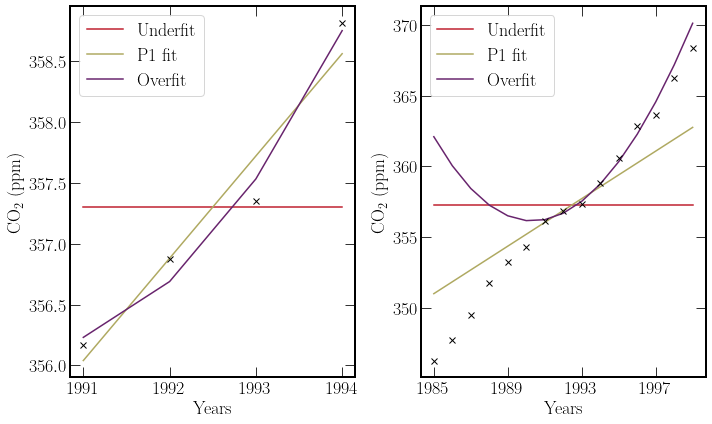

In [5]:

#Plotting
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
# First axis
ax[0].plot(fit_test['decimal'],
    p0(fit_test['decimal'], *p0_fit),
    label = 'Underfit',
    c = colours.durham.red
    )
ax[0].plot(fit_test['decimal'],
    p1(fit_test['decimal'], *p1_fit),
    label = 'P1 fit',
    c = colours.durham.green
    )
ax[0].plot(fit_test['decimal'],
    p3(fit_test['decimal'], *p3_fit),
    label = 'Overfit',
    c = colours.durham.purple
    )
ax[0].plot(fit_test['decimal'],
    fit_test['average'],
    linestyle = '',
    marker = 'x',
    c = 'black'
    )
ax[0].legend()
ax[0].set_xticks(fit_test['decimal'])
ax[0].set_xticklabels([i for i in range(1991,1995)])
ax[0].set_xlabel('Years')
ax[0].set_ylabel(r'$\textrm{{CO}}_2$ (ppm)')
#Extended Axis
ax[1].plot(fit_extension['decimal'],
    p0(fit_extension['decimal'], *p0_fit),
    label = 'Underfit',
    c = colours.durham.red
    )
ax[1].plot(fit_extension['decimal'],
    p1(fit_extension['decimal'], *p1_fit),
    label = 'P1 fit',
    c = colours.durham.green
    )
ax[1].plot(fit_extension['decimal'],
    p3(fit_extension['decimal'], *p3_fit),
    label = 'Overfit',
    c = colours.durham.purple)
ax[1].plot(fit_extension['decimal'],
    fit_extension['average'],
    linestyle = '',
    marker = 'x',
    c = 'black'
    )
ax[1].legend()
ax[1].set_xticks(fit_extension['decimal'].iloc[::4])
ax[1].set_xticklabels([i for i in range(1985,2000,4)])
ax[1].set_xlabel('Years')
ax[1].set_ylabel(r'$\textrm{{CO}}_2$ (ppm)')
None

Underfitting, shown in red in the above figure is characterised by a model with too few free parameters to characterise the data well. Underfitting results in poor model performance and a considerable value for the residuals. 

Overfitting behaviour, shown in purple is the opposite of underfitting, where there are too many free parameters. This is limited by most software packages as there are no unique solutions for the case where there are more free parameters than data-points. The consequence of overfitting is the poor generalisability of the model. It fits the specific dataset rather than more general trends. This, makes the predictive power of the model weak.

Both of these concepts are not rigid and for different applications the number of free parameters for a given dataset should be adjusted. The $\chi^2$ test can determine whether a fit is acceptable for a given critical value. 